<a href="https://colab.research.google.com/github/Suhit97/Image-captioning-using-tensorflow-keras/blob/master/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import os
import tensorflow as tf
import string
import pickle 
import time

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, BatchNormalization, Input
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from zipfile import ZipFile
from os.path import exists
from keras.utils.data_utils import get_file


In [3]:
# Load data
images_dir = os.listdir("/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/")

images_path = '/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/Images/'
captions_path = '/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
START = "startseq"
STOP = "endseq"
EPOCHS = 10

In [4]:
text = open(captions_path, 'r', encoding = 'utf-8').read()
print(text[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [5]:
def load_description(captions):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

descriptions = load_description(text)
print("Number of items: " + str(len(descriptions)))

Number of items: 8092


In [6]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)

In [7]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)
len(vocab)

8763

In [8]:
import glob
# Create a list of all image names in the directory
img = glob.glob(images_path + '*.jpg')
len(img)

8091

In [9]:
train_img = []

for im in img:
    if(im[len(images_path):] in x_train):
        train_img.append(im)
len(train_img)

6000

In [10]:
test_img = []

for im in img:
    if(im[len(images_path): ] in x_test):
        test_img.append(im)
len(test_img)

1000

In [11]:
#load descriptions of train and test set separately
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, x_train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [12]:

def preprocess_img(img_path):
    #inception v3 excepts img in 299*299
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [ ]:
base_model = InceptionV3(weights = 'imagenet')
base_model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
model = Model(base_model.input, base_model.layers[-2].output)

In [ ]:
#function to encode an image into a vector using inception v3
def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [ ]:
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
print("Time Taken is: " + str(time.time() - start))

In [ ]:
with open('/content/gdrive/My Drive/Flickr/train_encoded_images.p', "wb") as fp:
       pickle.dump(encoding_train, fp)

In [ ]:
#Encode all the test images
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)
print("Time taken is: " + str(time.time() - start))


Time taken is: 288.973397731781


In [ ]:
with open('/content/gdrive/My Drive/Flickr/test_encoded_images.p', "wb") as fp:
       pickle.dump(encoding_test, fp)

In [65]:
with open('/content/gdrive/My Drive/Flickr/train_encoded_images.p', 'rb') as f:
    train_features = pickle.load(f, encoding="bytes")
with open('/content/gdrive/My Drive/Flickr/test_encoded_images.p', 'rb') as f:
    test_features = pickle.load(f, encoding="bytes")


print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [20]:
#list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
len(all_train_captions)

30000

In [21]:
#onsider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 7578
our Vocabulary: 1651


In [22]:
#word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [23]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

1652

In [24]:
#find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

In [25]:


#since there are almost 30000 descriptions to process we will use datagenerator
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)


(292328, 2048)


In [29]:
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'

In [ ]:


if not exists('/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/' + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path='/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/')

2176770048/2176768927 [==============================] - 1014s 0us/step


In [30]:
embeddings_index = {}
with open('/content/gdrive/My Drive/Flickr/flickr_data/Flickr_Data/' + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Word embeddings: 2196016


In [31]:
emb_dim = 300
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 300)

In [57]:
# define the model


ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))

se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 300)      495600      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 2048)         0           input_7[0][0]                    
_______________________________________________________________________________________

In [58]:
model.layers[2]

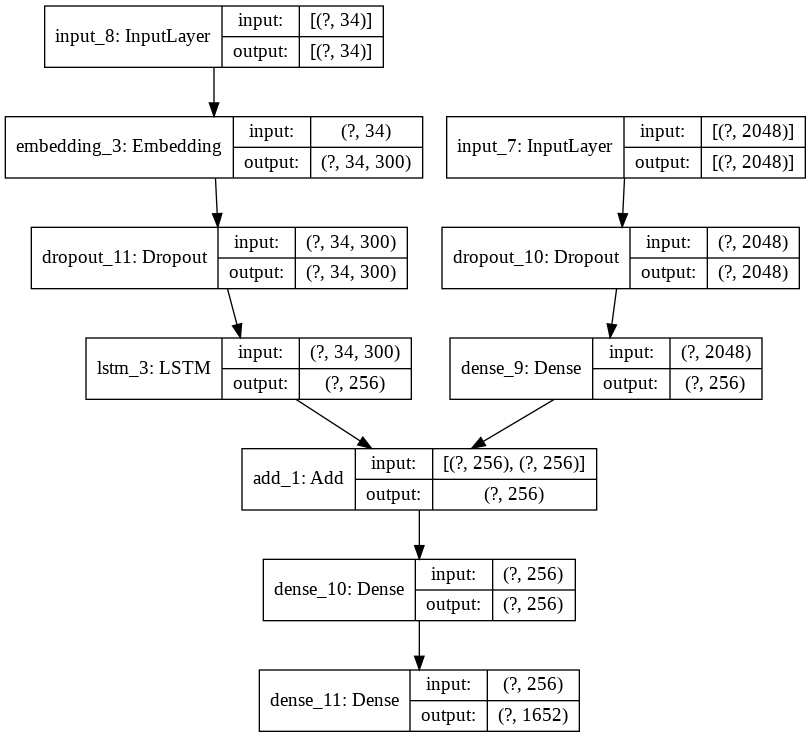

In [60]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

In [ ]:
model_2 = Model(inputs = [ip1, ip2], outputs = outputs)
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False

model_2.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
for i in range(30):
    model_2.fit([X1, X2], y, epochs = 1, batch_size = 256)
    if(i%2 == 0):
        model_2.save_weights("image-caption-weights" + str(i) + ".h5")

 683/1142 [================>.............] - ETA: 42s - loss: 2.0843

KeyboardInterrupt: ignored

In [61]:
hist = model.fit([X1, X2], y, batch_size=256, epochs=30) ## would give far better results if done for 200 epochs

Epoch 1/30
1142/1142 [==============================] - 97s 85ms/step - loss: 3.8234 - accuracy: 0.2711
Epoch 2/30
1142/1142 [==============================] - 97s 85ms/step - loss: 3.0936 - accuracy: 0.3338
Epoch 3/30
1142/1142 [==============================] - 97s 85ms/step - loss: 2.8618 - accuracy: 0.3593
Epoch 4/30
1142/1142 [==============================] - 97s 85ms/step - loss: 2.7114 - accuracy: 0.3759
Epoch 5/30
1142/1142 [==============================] - 94s 82ms/step - loss: 2.5940 - accuracy: 0.3895
Epoch 6/30
1142/1142 [==============================] - 99s 87ms/step - loss: 2.4975 - accuracy: 0.4021
Epoch 7/30
1142/1142 [==============================] - 97s 85ms/step - loss: 2.4156 - accuracy: 0.4124
Epoch 8/30
1142/1142 [==============================] - 96s 84ms/step - loss: 2.3432 - accuracy: 0.4224
Epoch 9/30
1142/1142 [==============================] - 98s 86ms/step - loss: 2.2803 - accuracy: 0.4314
Epoch 10/30
1142/1142 [==============================] - 96s 84m

In [ ]:
model.save_weights("model_weights.h5")

## Trying another approach

In [ ]:
model_2 = Model(inputs = [ip1, ip2], outputs = outputs)
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False

model_2.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])



for i in range(30):
    model_2.fit([X1, X2], y, epochs = 1, batch_size = 256)
    if(i%2 == 0):
        model_2.save_weights("image-caption-weights" + str(i) + ".h5")

In [62]:

def cap_predict(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

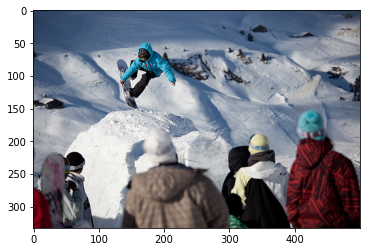

group of people stand in the snow in front of mountain


In [68]:
pic = list(test_features.keys())[250]
img = test_features[pic].reshape(1, 2048)
x = plt.imread(images_path + pic)
plt.imshow(x)
plt.show()
print(cap_predict(img))

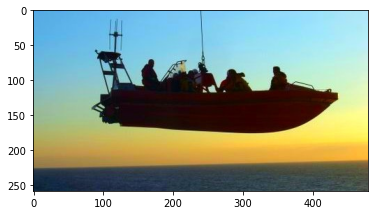

boat in the water


In [69]:
pic = list(test_features.keys())[420]
img = test_features[pic].reshape(1, 2048)
x = plt.imread(images_path + pic)
plt.imshow(x)
plt.show()
print(cap_predict(img))